# Figure 1: The Magellanic System in an orthographic projection

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import Normalize
from matplotlib import cm as cmapper
from matplotlib.colors import LogNorm
from matplotlib import cm

import cartopy.crs as ccrs

from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astropy.table import QTable

from spectral_cube import SpectralCube

%matplotlib notebook

In [2]:
#Load High ion absorption line measurements
with open("Data/HIGH_ION_MAP_DATA.pkl", "rb") as f:
    high_ion_data = pickle.load(f)
    
# #Load HI Milky Way Background Data
# with open("Data/MW_HI.pkl", "rb") as f:
#     mw_data = pickle.load(f)

# #Load HI Magellanic Data
# with open("Data/STREAM_HI.pkl", "rb") as f:
#     stream_data = pickle.load(f)

In [3]:
# Set some Initial parameters to plot
source_gal = high_ion_data["SOURCE_COORDS"]
lmc_gal = high_ion_data["LMC_COORD"]

ZZ = high_ion_data["CIV"]
VZ = high_ion_data["v"]
ZZ_UL = high_ion_data["CIV_UL"]

cmap2 = sns.color_palette("YlOrBr_r", as_cmap=True)

cmap = sns.color_palette("mako", as_cmap=True)

In [5]:
high_ion_data["b"]

array([ 6.73809061, 35.27897738, 34.84783719,  5.58284311, 13.82286391,
       42.69080167,  7.91413419, 13.02869289, 11.56735637, 42.86609215,
        6.76101035, 15.58367648, 17.97987862,  3.24829491, 12.48654041,
       26.54503213,  9.86112393, 22.20024646, 35.59066612, 15.92866702,
       37.41096327, 37.04679733, 39.37082432,  8.0715409 , 31.35142973,
       15.87299632, 46.05462368, 25.29519037])

In [4]:
# Get impact parameter contours
levels = [5, 15, 30, 45]
gridx = -Angle(np.arange(200,340,1.)*u.deg).wrap_at("180d").value
gridy = np.arange(-85,15,1.)
xx, yy = np.meshgrid(gridx, gridy, indexing = "ij")
coords = SkyCoord(l = xx*u.deg, b = yy*u.deg, frame = "galactic")
distance = 50*u.kpc
LMC_gal_flipped = SkyCoord(l = -lmc_gal.l.wrap_at("180d"), b = lmc_gal.b, frame = "galactic")
impact_par_grid = np.tan(LMC_gal_flipped.separation(coords)) * distance

In [5]:
# Get masks for Stream and Bridge Direcitons
stream_mask = np.array([b in high_ion_data["stream_Bs"] for b in high_ion_data["b"]])
bridge_mask = np.array([b in high_ion_data["bridge_Bs"] for b in high_ion_data["b"]])

In [6]:
# Set normalization ranges
col_den_factor = 1.823*10**18 * u.cm**-2 / (u.K * u.km/u.s)
clip_value = 10**18* u.cm**-2
clip_value2 = 10**20* u.cm**-2

norm = LogNorm(vmin = clip_value.to(u.cm**-2).value, vmax = 5e21)
norm_lin = Normalize(vmin = 18, vmax = 21.7)
norm2 = LogNorm(vmin = clip_value2.to(u.cm**-2).value, vmax = 1e25)

## Column Density Map

<IPython.core.display.Javascript object>


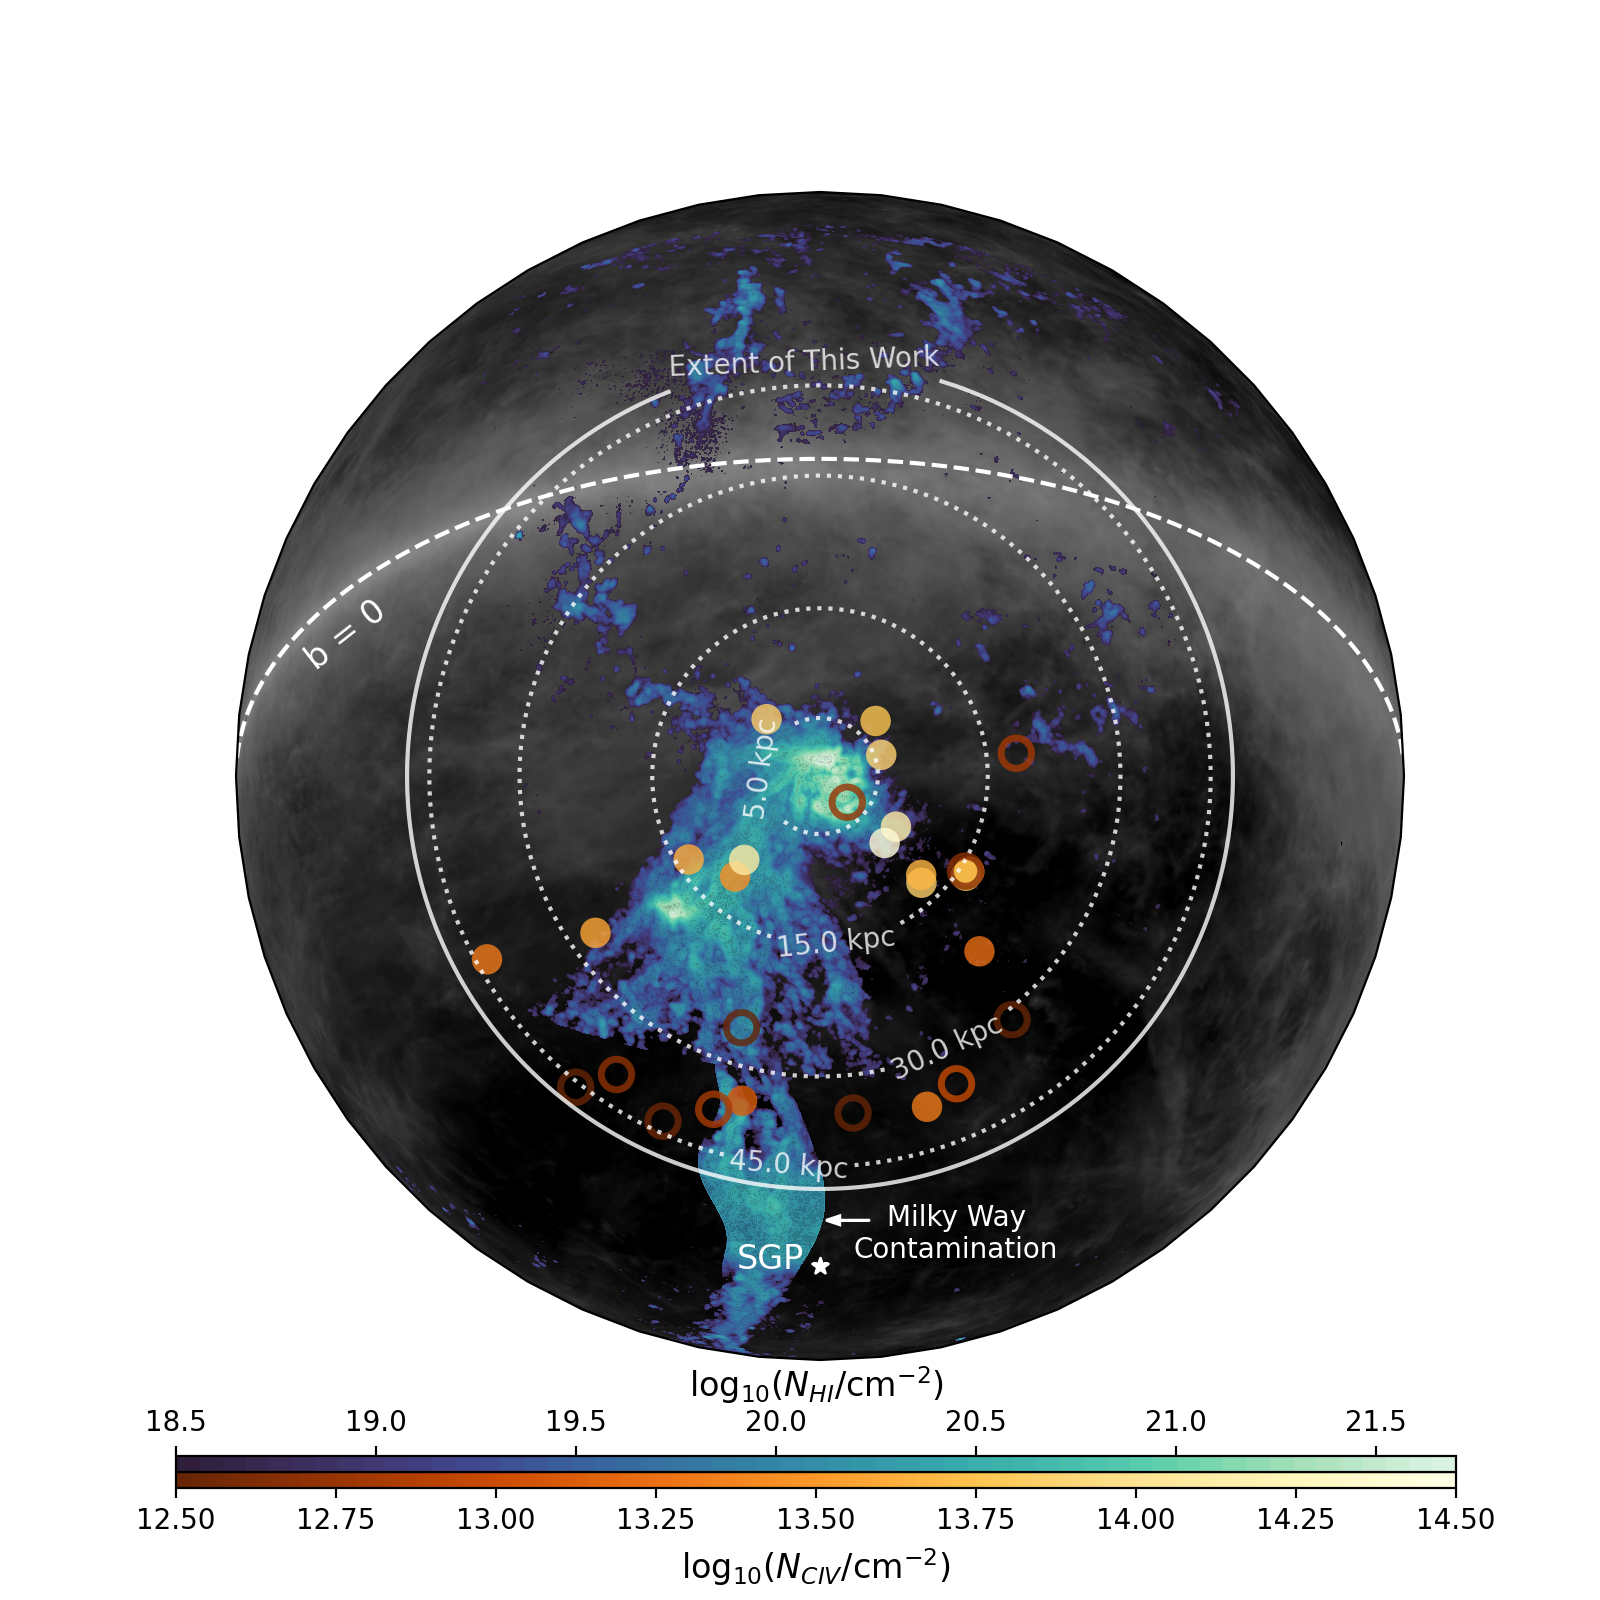

Text(1486520.0, -5000000.0, 'Milky Way\nContamination')

In [7]:
fig = plt.figure(figsize = (8,8))

# Orthographic Projection
ax = fig.add_subplot(projection=ccrs.Orthographic(central_longitude=LMC_gal_flipped.l.wrap_at("180d").value[0], 
                                                  central_latitude=LMC_gal_flipped.b.value[0],))

#Background MW Image
im = ax.pcolormesh(mw_data["l"], mw_data["b"], mw_data["moment_18"], 
              shading='nearest', 
              transform = ccrs.PlateCarree(), norm = norm2, cmap = "Greys_r")

# Foreground Stream Image
im = ax.contourf(stream_data["l"], stream_data["b"], np.log10(stream_data["moment_18"]), 
              transform = ccrs.PlateCarree(), cmap = cmap, norm = norm_lin, alpha = 0.8, 
                 levels = np.log10(np.logspace(18.5,21.7,56)))


# CIV Points and Upper limits
nan_inf_mask = np.isnan(ZZ) | np.isinf(ZZ)
norm_CIV = Normalize(vmin = 12.5, vmax = 14.5)

sc = ax.scatter(-source_gal.l.value, source_gal.b.value, 
           transform = ccrs.PlateCarree(), 
           c = ZZ, 
           cmap = cmap2, 
           alpha = 0.8, 
           norm = norm_CIV, 
                s = 120, 
                edgecolor = "w", linestyle = "-", linewidth = 0.)



cmapper = cm.ScalarMappable(cmap = cmap2, norm = norm_CIV)
                

#Outlines Only for Upper Limits
sc = ax.scatter(-source_gal.l.value[nan_inf_mask], 
                source_gal.b.value[nan_inf_mask], 
           transform = ccrs.PlateCarree(), 
           c = ZZ[nan_inf_mask], 
           cmap = cmap2, 
           alpha = 0.8,
           norm = norm_CIV,  
                s = 120, 
                edgecolor = cmapper.to_rgba(ZZ_UL[nan_inf_mask]), 
                linestyle = "-", 
                linewidth = 2.5)





# Coordinate Labels

SP = ax.text(0,-85, "SGP",
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12)

_ = ax.scatter(0, -90, color = "w", marker = "*", 
               transform = ccrs.PlateCarree())

ll = np.arange(-180,179.9,.1)
bb = np.zeros_like(ll)

_ = ax.plot(ll, bb, ls = "--", color = "w", transform = ccrs.PlateCarree())

EQ = ax.text(25, -5, "b = 0", 
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12, rotation = 38)


# Impact Parameter Contours
ct = ax.contour(xx, yy, impact_par_grid, 
                levels = levels, 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = ":")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "{} kpc".format(lab)
ax.clabel(ct, ct.levels, fmt = fmt)

ct = ax.contour(xx, yy, impact_par_grid, 
                levels = [50], 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = "-")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "Extent of This Work"
manual_locations = [(-1.725e5,4.506e6),]
ax.clabel(ct, ct.levels, fmt = fmt, manual=manual_locations)


_ = ax.set_global()



# Add Colorbar
plt.subplots_adjust(bottom = .15)

cax = fig.add_axes([.11,.07,.8,.01])
cax2 = fig.add_axes([.11,.08,.8,.01])

cbar = plt.colorbar(sc, cax = cax, orientation = "horizontal")
cbar.solids.set(alpha=1)


cbar2 = plt.colorbar(im, cax = cax2, orientation = "horizontal", ticks = [18.5,19,19.5,20,20.5,21,21.5])
cbar2.solids.set(alpha=1)
cax2.xaxis.tick_top()
cax2.xaxis.set_label_position("top")

cax2.set_xlabel(r"$\log_{10}(N_{HI}/\mathrm{cm}^{-2})$", fontsize = 12)
cax.set_xlabel(r"$\log_{10}(N_{CIV}/\mathrm{cm}^{-2})$", fontsize = 12)

# Extra Label
ax.arrow(5.339e5,-4.852e6,-(5.339e5-5.759e4)/1.5,0, 
         head_width = 1e5, color = "w")
ax.text(5.339e5+(5.339e5-5.759e4)*2, -5e6, "Milky Way\nContamination", 
         va = "center", ha = "center", fontsize = 10, color = "w")



In [8]:
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/ColumnDensity_Map_Ortho.png", dpi = 300, 
            transparent = True)

<IPython.core.display.Javascript object>


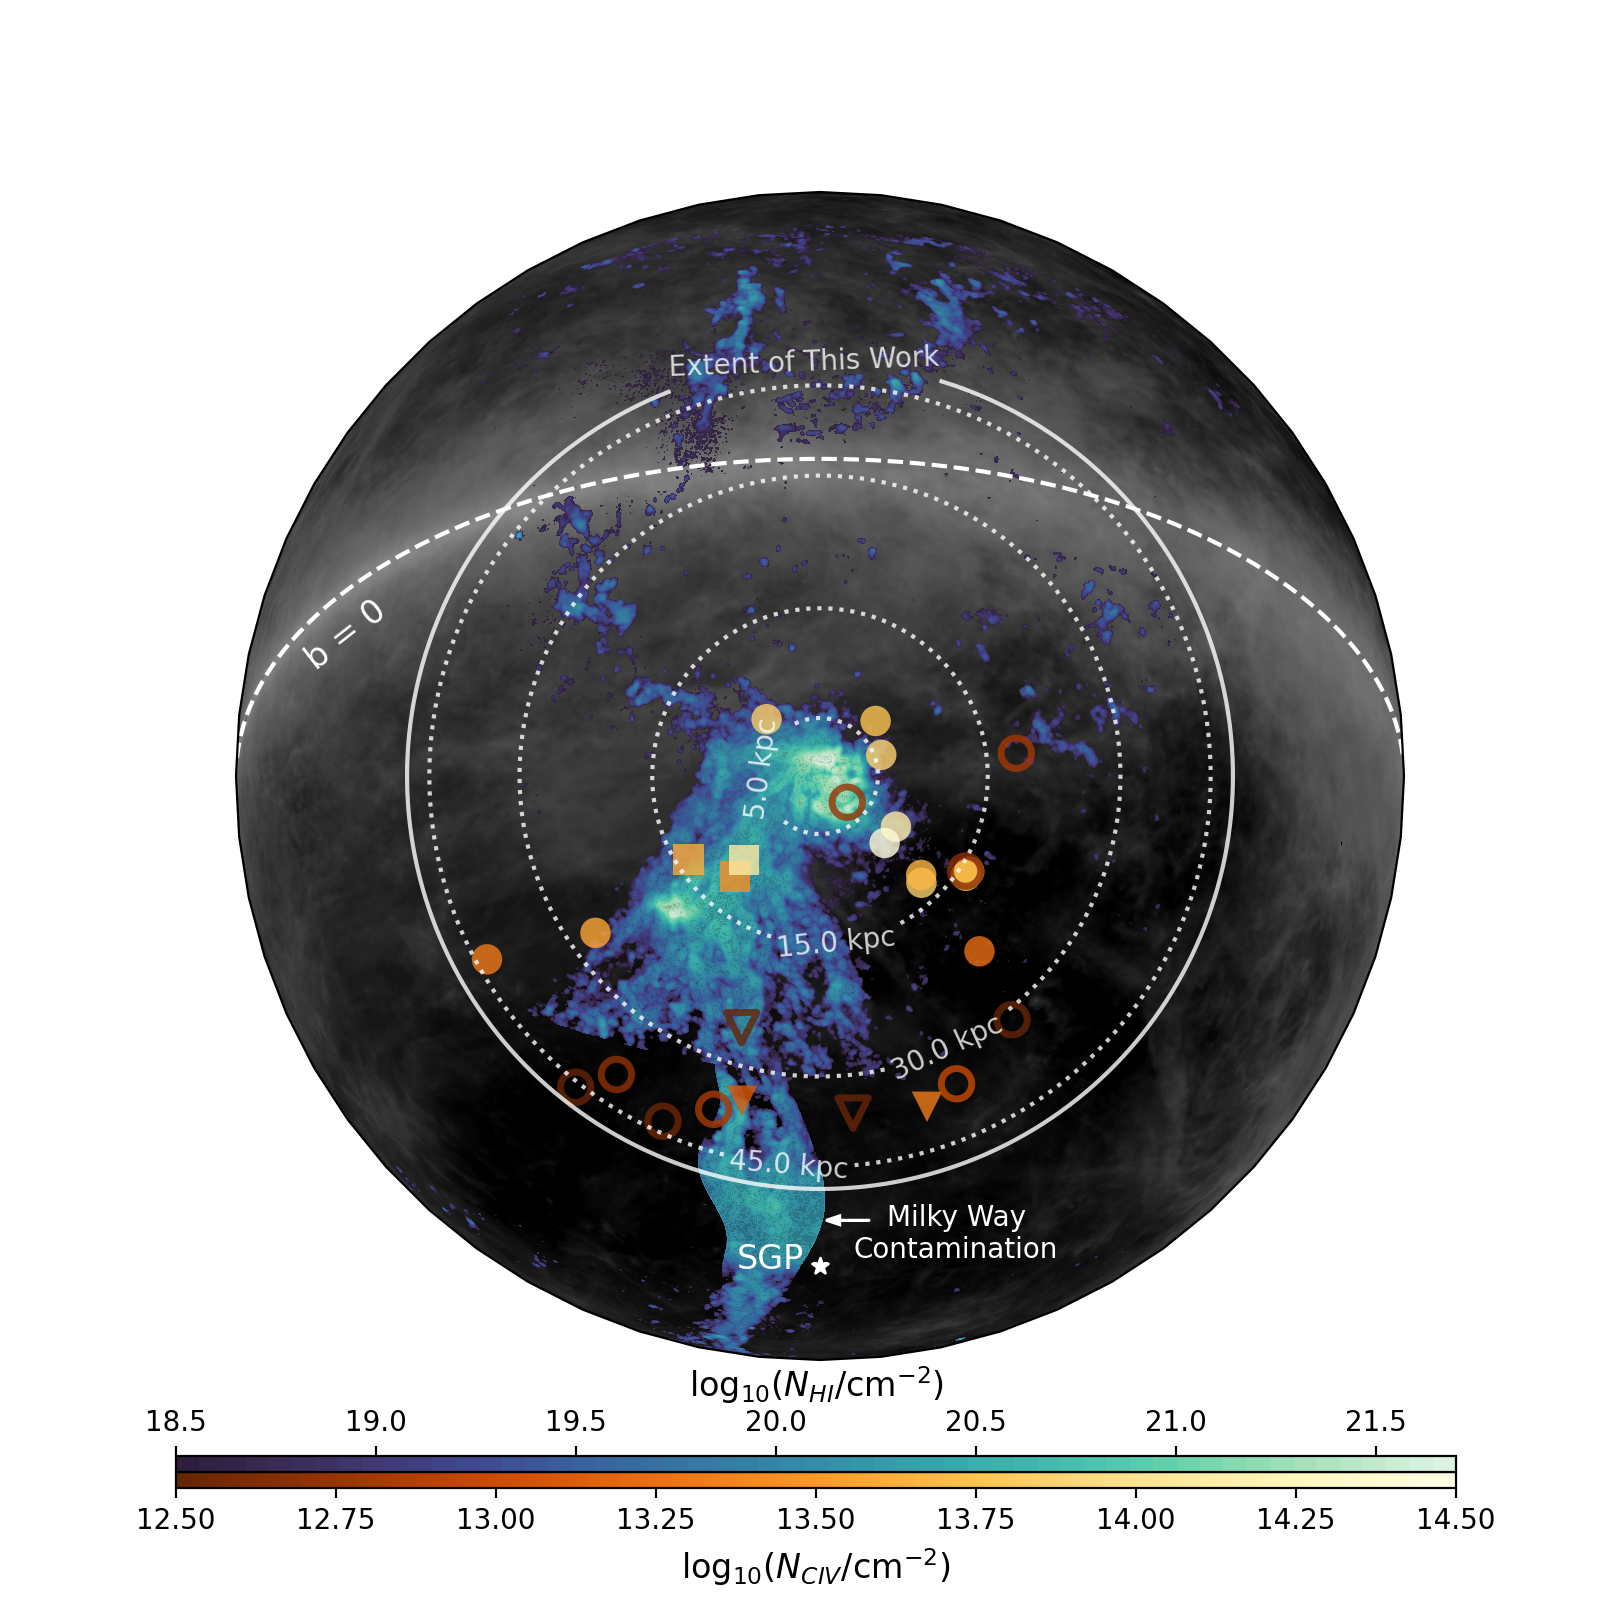

Text(1486520.0, -5000000.0, 'Milky Way\nContamination')

In [7]:
fig = plt.figure(figsize = (8,8))

# Orthographic Projection
ax = fig.add_subplot(projection=ccrs.Orthographic(central_longitude=LMC_gal_flipped.l.wrap_at("180d").value[0], 
                                                  central_latitude=LMC_gal_flipped.b.value[0],))

#Background MW Image
im = ax.pcolormesh(mw_data["l"], mw_data["b"], mw_data["moment_18"], 
              shading='nearest', 
              transform = ccrs.PlateCarree(), norm = norm2, cmap = "Greys_r")

# Foreground Stream Image
im = ax.contourf(stream_data["l"], stream_data["b"], np.log10(stream_data["moment_18"]), 
              transform = ccrs.PlateCarree(), cmap = cmap, norm = norm_lin, alpha = 0.8, 
                 levels = np.log10(np.logspace(18.5,21.7,56)))


# CIV Points and Upper limits
nan_inf_mask = np.isnan(ZZ) | np.isinf(ZZ)
norm_CIV = Normalize(vmin = 12.5, vmax = 14.5)

sc = ax.scatter(-source_gal.l.value[~stream_mask & ~bridge_mask], source_gal.b.value[~stream_mask & ~bridge_mask], 
           transform = ccrs.PlateCarree(), 
           c = ZZ[~stream_mask & ~bridge_mask], 
           cmap = cmap2, 
           alpha = 0.8, 
           norm = norm_CIV, 
                s = 120, 
                edgecolor = "w", linestyle = "-", linewidth = 0.)

sc = ax.scatter(-source_gal.l.value[bridge_mask], source_gal.b.value[bridge_mask], 
           transform = ccrs.PlateCarree(), 
           c = ZZ[bridge_mask], 
           cmap = cmap2, 
           alpha = 0.8, 
           norm = norm_CIV, 
                s = 120, 
                edgecolor = "w", 
                linestyle = "-", 
                linewidth = 0., 
                marker = "s")

sc = ax.scatter(-source_gal.l.value[stream_mask], source_gal.b.value[stream_mask], 
           transform = ccrs.PlateCarree(), 
           c = ZZ[stream_mask], 
           cmap = cmap2, 
           alpha = 0.8, 
           norm = norm_CIV, 
                s = 120, 
                edgecolor = "w", 
                linestyle = "-", 
                linewidth = 0., 
                marker = "v")

cmapper = cm.ScalarMappable(cmap = cmap2, norm = norm_CIV)
                

#Outlines Only for Upper Limits
sc = ax.scatter(-source_gal.l.value[~stream_mask & ~bridge_mask & nan_inf_mask], 
                source_gal.b.value[~stream_mask & ~bridge_mask & nan_inf_mask], 
           transform = ccrs.PlateCarree(), 
           c = ZZ[~stream_mask & ~bridge_mask & nan_inf_mask], 
           cmap = cmap2, 
           alpha = 0.8,
           norm = norm_CIV,  
                s = 120, 
                edgecolor = cmapper.to_rgba(ZZ_UL[~stream_mask & ~bridge_mask & nan_inf_mask]), 
                linestyle = "-", 
                linewidth = 2.5)

sc = ax.scatter(-source_gal.l.value[bridge_mask & nan_inf_mask], source_gal.b.value[bridge_mask & nan_inf_mask], 
           transform = ccrs.PlateCarree(), 
           c = ZZ[bridge_mask & nan_inf_mask], 
           cmap = cmap2, 
           alpha = 0.8, 
           norm = norm_CIV, 
                s = 120, 
                edgecolor = cmapper.to_rgba(ZZ_UL[bridge_mask & nan_inf_mask]), 
                linestyle = "-", 
                linewidth = 2.5, 
                marker = "s")

sc = ax.scatter(-source_gal.l.value[stream_mask & nan_inf_mask], source_gal.b.value[stream_mask & nan_inf_mask], 
           transform = ccrs.PlateCarree(), 
           c = ZZ[stream_mask & nan_inf_mask], 
           cmap = cmap2, 
           alpha = 0.8, 
           norm = norm_CIV, 
                s = 120, 
                edgecolor = cmapper.to_rgba(ZZ_UL[stream_mask & nan_inf_mask]), 
                linestyle = "-", 
                linewidth = 2.5, 
                marker = "v")



# Coordinate Labels

SP = ax.text(0,-85, "SGP",
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12)

_ = ax.scatter(0, -90, color = "w", marker = "*", 
               transform = ccrs.PlateCarree())

ll = np.arange(-180,179.9,.1)
bb = np.zeros_like(ll)

_ = ax.plot(ll, bb, ls = "--", color = "w", transform = ccrs.PlateCarree())

EQ = ax.text(25, -5, "b = 0", 
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12, rotation = 38)


# Impact Parameter Contours
ct = ax.contour(xx, yy, impact_par_grid, 
                levels = levels, 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = ":")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "{} kpc".format(lab)
ax.clabel(ct, ct.levels, fmt = fmt)

ct = ax.contour(xx, yy, impact_par_grid, 
                levels = [50], 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = "-")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "Extent of This Work"
manual_locations = [(-1.725e5,4.506e6),]
ax.clabel(ct, ct.levels, fmt = fmt, manual=manual_locations)


_ = ax.set_global()



# Add Colorbar
plt.subplots_adjust(bottom = .15)

cax = fig.add_axes([.11,.07,.8,.01])
cax2 = fig.add_axes([.11,.08,.8,.01])

cbar = plt.colorbar(sc, cax = cax, orientation = "horizontal")
cbar.solids.set(alpha=1)


cbar2 = plt.colorbar(im, cax = cax2, orientation = "horizontal", ticks = [18.5,19,19.5,20,20.5,21,21.5])
cbar2.solids.set(alpha=1)
cax2.xaxis.tick_top()
cax2.xaxis.set_label_position("top")

cax2.set_xlabel(r"$\log_{10}(N_{HI}/\mathrm{cm}^{-2})$", fontsize = 12)
cax.set_xlabel(r"$\log_{10}(N_{CIV}/\mathrm{cm}^{-2})$", fontsize = 12)

# Extra Label
ax.arrow(5.339e5,-4.852e6,-(5.339e5-5.759e4)/1.5,0, 
         head_width = 1e5, color = "w")
ax.text(5.339e5+(5.339e5-5.759e4)*2, -5e6, "Milky Way\nContamination", 
         va = "center", ha = "center", fontsize = 10, color = "w")



# Velocity Map

In [9]:
# vnorm_full = TwoSlopeNorm(vmin = -100, vmax = 400, vcenter = 0)
# vnorm_full = SymLogNorm(linthresh=10, vmin = -500, vmax = 500, base = 10, linscale = .25)
vnorm_full2 = Normalize(vmin = -450, vmax = 450)
# cmap_v = sns.diverging_palette(258.7, 12.2, l=70, center="dark", as_cmap=True)
cmap_v2 = sns.color_palette("icefire", as_cmap = True)
cmap_v = sns.color_palette("RdBu_r", as_cmap = True)


<IPython.core.display.Javascript object>


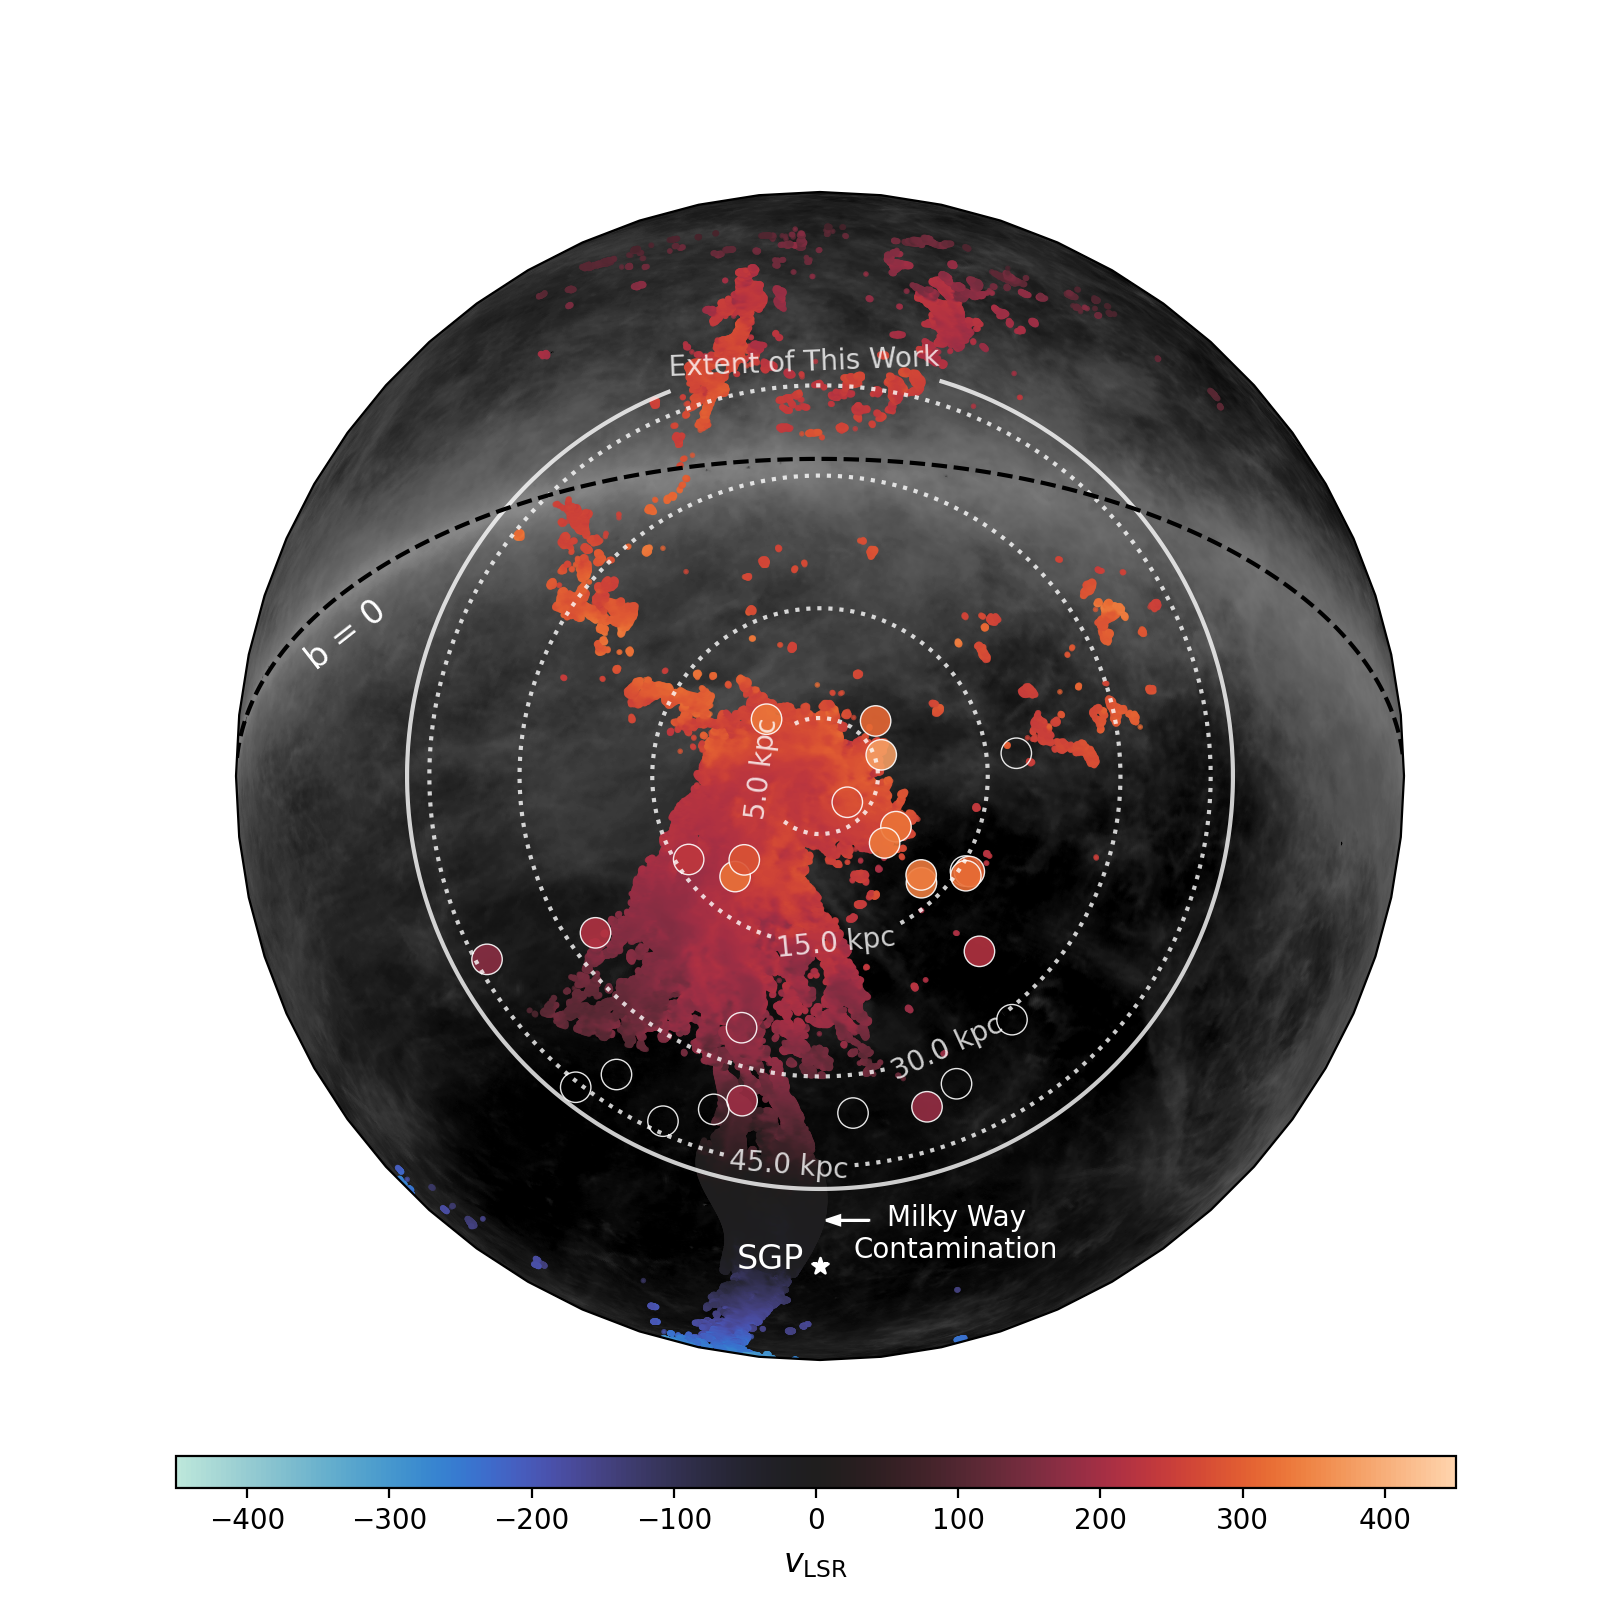

Text(1486520.0, -5000000.0, 'Milky Way\nContamination')

In [10]:
fig = plt.figure(figsize = (8,8))

# Orthographic Projection
ax = fig.add_subplot(projection=ccrs.Orthographic(central_longitude=LMC_gal_flipped.l.wrap_at("180d").value[0], 
                                                  central_latitude=LMC_gal_flipped.b.value[0],))

# MW Background
im = ax.pcolormesh(mw_data["l"], mw_data["b"], mw_data["moment_18"], 
              shading='nearest', 
              transform = ccrs.PlateCarree(), norm = norm2, cmap = "Greys_r")

# Stream Foreground
vmask = np.isnan(stream_data["vel"].value)
vmask |= np.log10(stream_data["moment_18"]) < 19
VEL_MAP = np.ma.masked_array(data = stream_data["vel"].value, mask = vmask)
im = ax.scatter(stream_data["l"], 
                   stream_data["b"], 
                   c = VEL_MAP, 
              transform = ccrs.PlateCarree(), 
                norm = vnorm_full2, 
                cmap = cmap_v2, 
                alpha = 0.7, 
                s = 1, 
                rasterized = True)

# CIV Data
sc = ax.scatter(-source_gal.l.value, source_gal.b.value, 
           transform = ccrs.PlateCarree(), 
           c = VZ, 
           cmap = cmap_v2, 
           alpha = 0.9, 
           norm = vnorm_full2,
                s = 120, edgecolor = "w", lw = 0.5)


# Coordinate Labels
SP = ax.text(0,-85, "SGP",
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12)

_ = ax.scatter(0, -90, color = "w", marker = "*", 
               transform = ccrs.PlateCarree())

ll = np.arange(-180,179.9,.1)
bb = np.zeros_like(ll)

_ = ax.plot(ll, bb, ls = "--", color = "k", transform = ccrs.PlateCarree())

EQ = ax.text(25, -5, "b = 0", 
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12, rotation = 38)


# Impact Parameter Contours
ct = ax.contour(xx, yy, impact_par_grid, 
                levels = levels, 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = ":")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "{} kpc".format(lab)
ax.clabel(ct, ct.levels, fmt = fmt)

ct = ax.contour(xx, yy, impact_par_grid, 
                levels = [50], 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = "-")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "Extent of This Work"
manual_locations = [(-1.725e5,4.506e6),]
ax.clabel(ct, ct.levels, fmt = fmt, manual=manual_locations)


_ = ax.set_global()

# Add Colorbar
plt.subplots_adjust(bottom = .15)
cax = fig.add_axes([.11,.07,.8,.02])
cbar = plt.colorbar(sc, cax = cax, orientation = "horizontal")
cbar.solids.set(alpha=1)

cax.set_xlabel(r"$v_\mathrm{LSR}$", fontsize = 12)

# Extra Label
ax.arrow(5.339e5,-4.852e6,-(5.339e5-5.759e4)/1.5,0, 
         head_width = 1e5, color = "w")
ax.text(5.339e5+(5.339e5-5.759e4)*2, -5e6, "Milky Way\nContamination", 
         va = "center", ha = "center", fontsize = 10, color = "w")




In [11]:
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/Cloudy/Velocity_Map_Ortho.png", dpi = 300, 
            transparent = True)

<IPython.core.display.Javascript object>


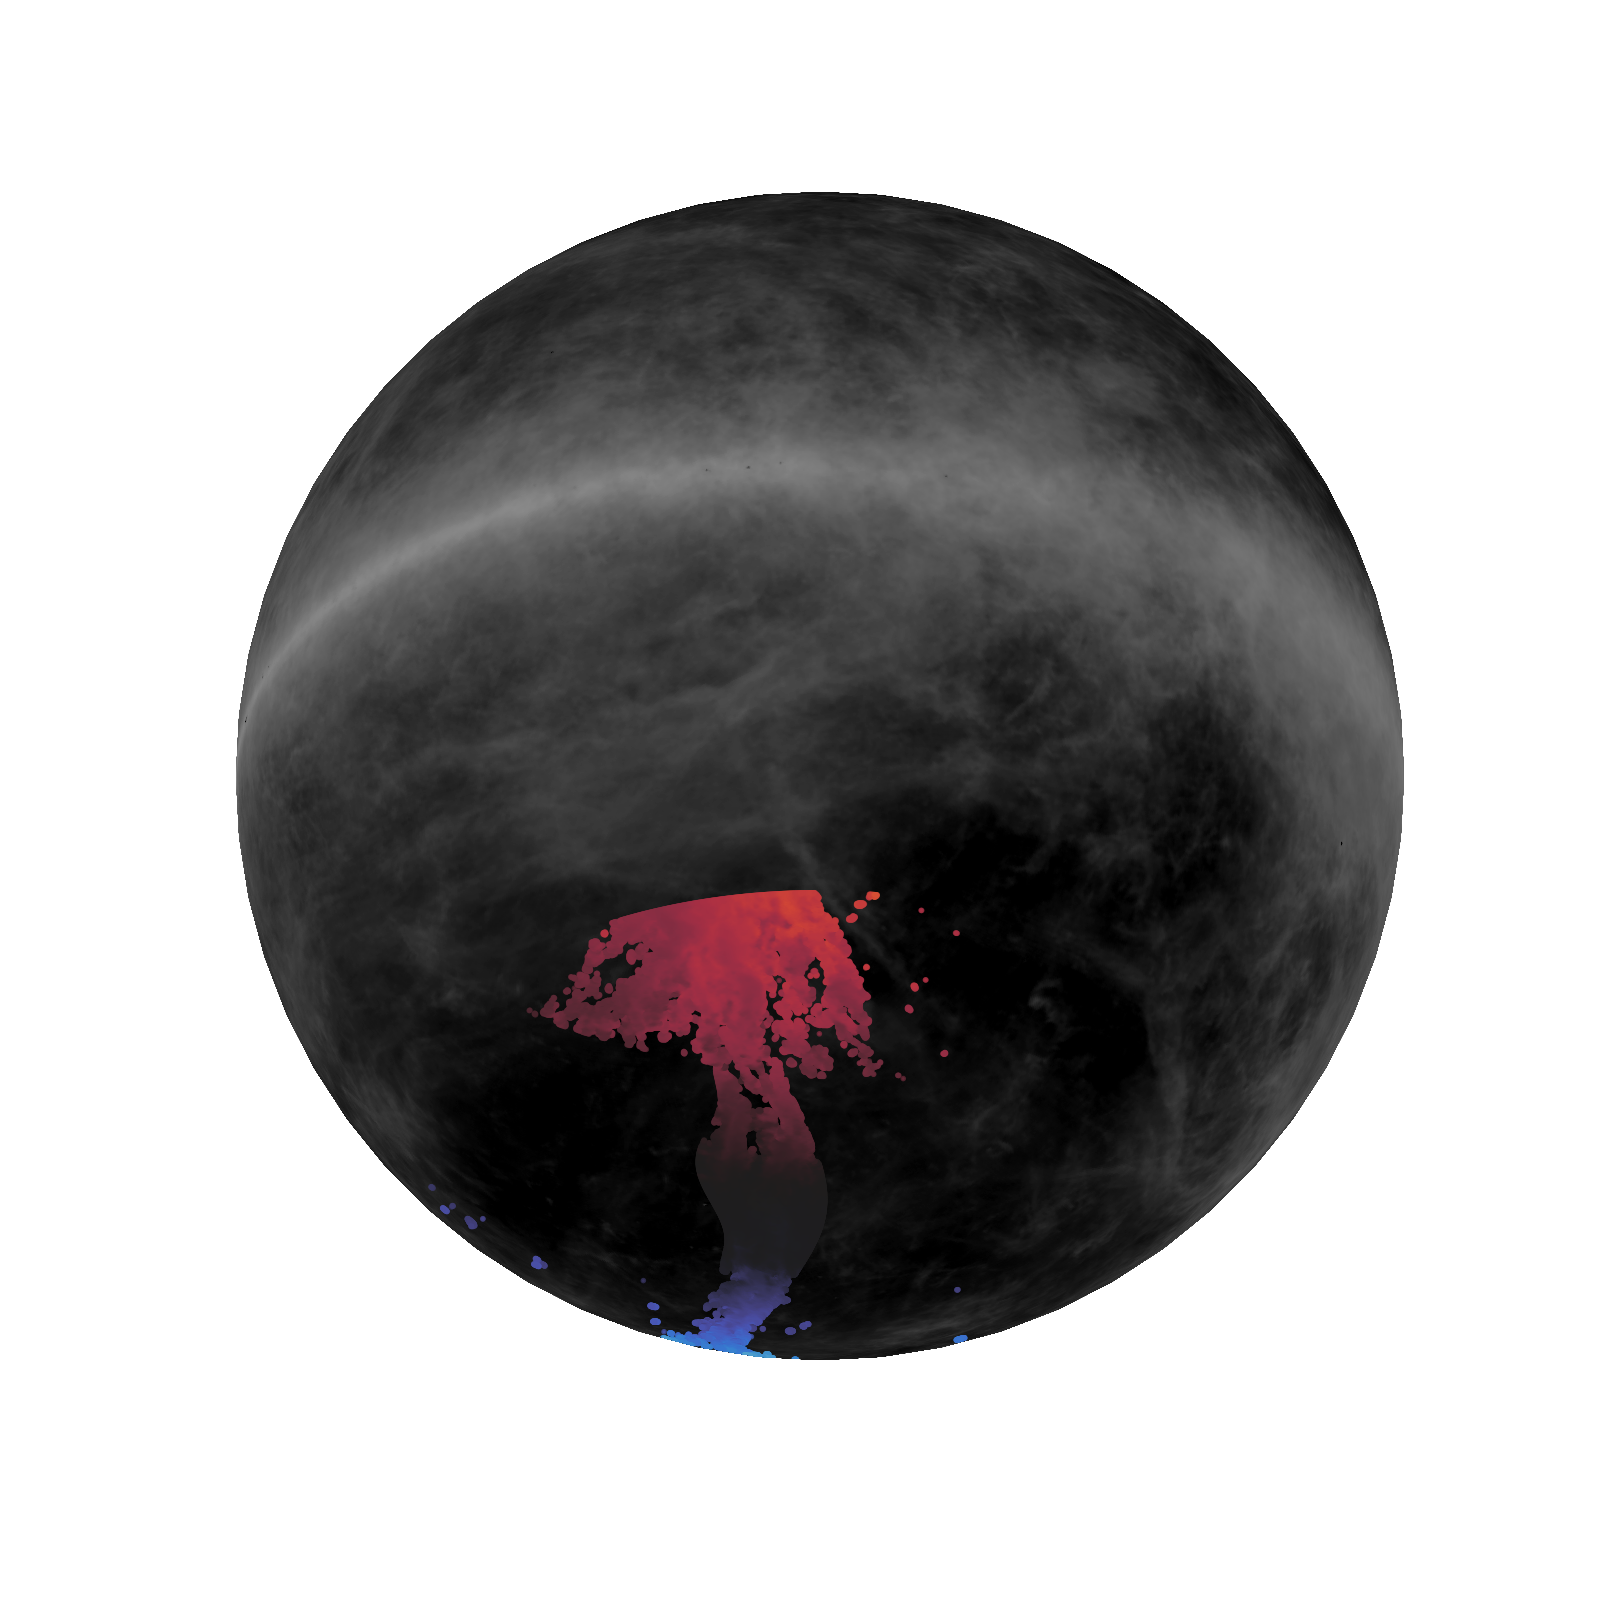

Text(1486520.0, -5000000.0, 'Milky Way\nContamination')

In [9]:
fig = plt.figure(figsize = (8,8))

# Orthographic Projection
ax = fig.add_subplot(projection=ccrs.Orthographic(central_longitude=LMC_gal_flipped.l.wrap_at("180d").value[0], 
                                                  central_latitude=LMC_gal_flipped.b.value[0],))

# MW Background
im = ax.pcolormesh(mw_data["l"], mw_data["b"], mw_data["moment_18"], 
              shading='nearest', 
              transform = ccrs.PlateCarree(), norm = norm2, cmap = "Greys_r")

# Stream Foreground
vmask = np.isnan(stream_data["vel"].value)
vmask |= np.log10(stream_data["moment_18"]) < 19
VEL_MAP = np.ma.masked_array(data = stream_data["vel"].value, mask = vmask)
im = ax.scatter(stream_data["l"], 
                   stream_data["b"], 
                   c = VEL_MAP, 
              transform = ccrs.PlateCarree(), 
                norm = vnorm_full2, 
                cmap = cmap_v2, 
                alpha = 0.7, 
                s = 1, 
                rasterized = True)

# CIV Data
sc = ax.scatter(-source_gal.l.value[~stream_mask & ~bridge_mask], source_gal.b.value[~stream_mask & ~bridge_mask], 
           transform = ccrs.PlateCarree(), 
           c = VZ[~stream_mask & ~bridge_mask], 
           cmap = cmap_v2, 
           alpha = 0.9, 
           norm = vnorm_full2,
                s = 120, edgecolor = "w", lw = 0.5)

sc = ax.scatter(-source_gal.l.value[stream_mask], source_gal.b.value[stream_mask], 
           transform = ccrs.PlateCarree(), 
           c = VZ[stream_mask], 
           cmap = cmap_v2, 
           alpha = 0.9, 
           norm = vnorm_full2,
                s = 120, marker = "v", edgecolor = "w", lw = 0.5)

sc = ax.scatter(-source_gal.l.value[bridge_mask], source_gal.b.value[bridge_mask], 
           transform = ccrs.PlateCarree(), 
           c = VZ[bridge_mask], 
           cmap = cmap_v2, 
           alpha = 0.9, 
           norm = vnorm_full2,
                s = 120, marker = "s", edgecolor = "w", lw = 0.5)

# Coordinate Labels
SP = ax.text(0,-85, "SGP",
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12)

_ = ax.scatter(0, -90, color = "w", marker = "*", 
               transform = ccrs.PlateCarree())

ll = np.arange(-180,179.9,.1)
bb = np.zeros_like(ll)

_ = ax.plot(ll, bb, ls = "--", color = "k", transform = ccrs.PlateCarree())

EQ = ax.text(25, -5, "b = 0", 
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12, rotation = 38)


# Impact Parameter Contours
ct = ax.contour(xx, yy, impact_par_grid, 
                levels = levels, 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = ":")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "{} kpc".format(lab)
ax.clabel(ct, ct.levels, fmt = fmt)

ct = ax.contour(xx, yy, impact_par_grid, 
                levels = [50], 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = "-")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "Extent of This Work"
manual_locations = [(-1.725e5,4.506e6),]
ax.clabel(ct, ct.levels, fmt = fmt, manual=manual_locations)


_ = ax.set_global()

# Add Colorbar
plt.subplots_adjust(bottom = .15)
cax = fig.add_axes([.11,.07,.8,.02])
cbar = plt.colorbar(sc, cax = cax, orientation = "horizontal")
cbar.solids.set(alpha=1)

cax.set_xlabel(r"$v_\mathrm{LSR}$", fontsize = 12)

# Extra Label
ax.arrow(5.339e5,-4.852e6,-(5.339e5-5.759e4)/1.5,0, 
         head_width = 1e5, color = "w")
ax.text(5.339e5+(5.339e5-5.759e4)*2, -5e6, "Milky Way\nContamination", 
         va = "center", ha = "center", fontsize = 10, color = "w")


